In [13]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import pymaster as nmt
import scipy.linalg as LA
plt.rcParams['font.family'] = 'sans-serif'  

In [14]:
#import all
import sys
sys.path.append("../lib")
from tqdm import tqdm
import pysm_common as psm

import numpy as np
import healpy as hp
import pymaster as nmt 
import pysm3
import time
from mpfit import mpfit
import mpfitlib as mpl
import scipy
#from Nearest_Positive_Definite import *
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patheffects as path_effects
import scipy.stats as st
import basicfunc as func
import analys_lib as an
import simu_lib as sim
import pysm3.units as u

#sim params

r = 0
nside = 32
Npix = hp.nside2npix(nside)
N= 4000
lmax = nside*2-1
#lmax=850
scale = 10
Nlbin = 10
fsky = 1
dusttype = 0
syncrotype = 0
kw = ''


# instr param

ifreq=[0,9,10,21]
instr_name='litebird_full'
instr =  np.load("../lib/instr_dict/%s.npy"%instr_name,allow_pickle=True).item()
freq= instr['frequencies']
sens_P= instr['sens_P']
freq=freq[ifreq]
sens_P=sens_P[ifreq]
sigpix= sens_P/(np.sqrt((4*np.pi)/Npix*(60*180/np.pi)**2))
b = nmt.bins.NmtBin(nside=nside,lmax=lmax,nlb=Nlbin)
leff = b.get_effective_ells()
N_freqs =len(freq)
Ncross=int(N_freqs*(N_freqs+1)/2)
sigpix= [sigpix[i]*psm.convert_units('uK_CMB','uK_RJ',freq[i]) for i in range(N_freqs)]

nucross = []
for i in range(0,N_freqs):
    for j in range(i,N_freqs):
        nucross.append(np.sqrt(freq[i]*freq[j]))
nucross = np.array(nucross)


#cmb
CLcmb_or=hp.read_cl('../CLsimus/Cls_Planck2018_r0.fits') #TT EE BB TE
DL_lens = b.bin_cell(CLcmb_or[2,2:lmax+3])
DLtp=[]
for i in range(0,N_freqs):
    for j in range(i,N_freqs):
        DLtp.append(DL_lens*psm.convert_units('uK_CMB','uK_RJ',freq[i])*psm.convert_units('uK_CMB','uK_RJ',freq[j]))
DL_lens= np.array(DLtp)
#mask
if fsky==1:
    mask =  np.ones(Npix)
else:
    mask = hp.read_map("../masks/mask_fsky%s_nside%s_aposcale%s.npy"%(fsky,nside,scale))

#call foreground sky
if dusttype==None and syncrotype==None:
    mapfg=np.zeros((N_freqs,2,Npix))
else:
    if dusttype==None:
        sky = pysm3.Sky(nside=512, preset_strings=['s%s'%syncrotype])#,'s%s'%synctype])
    if syncrotype==None:
        sky = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype])#,'s%s'%synctype])
    if syncrotype!=None and dusttype!=None:
        sky = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype,'s%s'%syncrotype])
    mapfg= np.array([sim.downgrade_map(sky.get_emission(freq[f] * u.GHz).to(u.uK_RJ, equivalencies=u.cmb_equivalencies(freq[f]*u.GHz)),nside_in=512,nside_out=nside) for f in range(len(freq))])
    mapfg=mapfg[:,1:]


In [15]:
# create N sims
noisemaps= np.zeros((N,3,N_freqs,2,Npix))
mapcmb = np.zeros((N,N_freqs,2,Npix))

for k in tqdm(range(0,N)):
    for p in range(3):
        for i in range(N_freqs):
            noisemaps[k,p,i,0] =np.random.normal(0,sigpix[i],size=Npix)
            noisemaps[k,p,i,1] =np.random.normal(0,sigpix[i],size=Npix)
    
    mapcmb0= hp.synfast(CLcmb_or,nside,pixwin=False,new=True)
    mapcmb1 = np.array([mapcmb0*psm.convert_units('uK_CMB','uK_RJ',freq[i]) for i in range(N_freqs)])
    mapcmb[k] = mapcmb1[:,1:]


100%|██████████| 4000/4000 [00:38<00:00, 103.73it/s]


In [16]:
#workspace
wsp_dc=[]
for i in range(0,N_freqs): 
    for j in range(i,N_freqs):
        w_dc = nmt.NmtWorkspace()
        if i != j :
            w_dc.compute_coupling_matrix(nmt.NmtField(mask, 1*mapfg[i],purify_e=False, purify_b=True), nmt.NmtField(mask,1*mapfg[j],purify_e=False, purify_b=True), b)
        if i==j :
            w_dc.compute_coupling_matrix(nmt.NmtField(mask, 1*mapfg[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*mapfg[j],purify_e=False, purify_b=True), b)
        wsp_dc.append(w_dc)
 
wsp_dc=np.array(wsp_dc)

def computecross(map_FM1,map_FM2,map_HM1,map_HM2):
    CLcross=np.zeros((Ncross,len(leff)))
    z=0
    for i in range(0,N_freqs):
        for j in range(i,N_freqs):
            if i != j :
                CLcross[z]=np.array((sim.compute_master(nmt.NmtField(mask, 1*map_FM1[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*map_FM2[j],purify_e=False, purify_b=True), wsp_dc[z]))[3])
            if i==j :
                CLcross[z]=np.array((sim.compute_master(nmt.NmtField(mask, 1*map_HM1[i],purify_e=False, purify_b=True), nmt.NmtField(mask, 1*map_HM2[j],purify_e=False, purify_b=True), wsp_dc[z]))[3])
            z = z +1
    return CLcross

DLcross_coadd= np.zeros((N,Ncross,len(leff)))

for k in tqdm(range(0,N)):
    #addition du bruit aux cartes
    map_FM =    mapfg +  noisemaps[k,0] + mapcmb[k]
    map_HM1 =   mapfg +  noisemaps[k,1]*np.sqrt(2) + mapcmb[k]
    map_HM2 =   mapfg +  noisemaps[k,2]*np.sqrt(2) + mapcmb[k] 
    DLcross_coadd[k]= computecross(map_FM,map_FM,map_HM1,map_HM2)

DLcross_fg = computecross(mapfg,mapfg,mapfg,mapfg)

100%|██████████| 4000/4000 [21:27<00:00,  3.11it/s]


In [17]:
DL_cross_noise=np.ones((Ncross,len(leff)))
z=0
for i in range(0,N_freqs): 
    for j in range(i,N_freqs):
        DL_cross_noise[z]= 4*np.pi*sigpix[i]*sigpix[j]/Npix*DL_cross_noise[z]
        z=z+1

In [18]:
from collections import Counter

def max_rep(arr):
    counts = Counter(arr)  
    return max(counts.values()) 

def cov_analytic(nu_i,nu_j,nu_k,nu_l,corrfog=True):
    A = np.argwhere(freq==nu_i)[0,0]
    B = np.argwhere(freq==nu_j)[0,0]
    C = np.argwhere(freq==nu_k)[0,0]
    D = np.argwhere(freq==nu_l)[0,0]
    Nunique = max_rep([A,B,C,D])
    poscrossAA= np.argwhere(nucross==np.sqrt(nu_i*nu_i))[0,0]
    poscrossBB= np.argwhere(nucross==np.sqrt(nu_j*nu_j))[0,0]
    poscrossAB= np.argwhere(nucross==np.sqrt(nu_i*nu_j))[0,0]
    poscrossCD= np.argwhere(nucross==np.sqrt(nu_k*nu_l))[0,0]
    poscrossAC= np.argwhere(nucross==np.sqrt(nu_i*nu_k))[0,0]
    poscrossBD= np.argwhere(nucross==np.sqrt(nu_j*nu_l))[0,0]
    poscrossAD= np.argwhere(nucross==np.sqrt(nu_i*nu_l))[0,0]
    poscrossBC= np.argwhere(nucross==np.sqrt(nu_j*nu_k))[0,0]

    v_l = (2*leff+1)*Nlbin*fsky
    
    if nu_i ==nu_k and nu_j == nu_l:
        if nu_i==nu_j:
            DLAB =  DL_lens[poscrossAA] + 2*DL_cross_noise[poscrossAA] +DLcross_fg[poscrossAA]
            DLAA =  DLAB 
            DLBB =  DLAB
        else:
            DLAB = DLcross_fg[poscrossAB] + DL_lens[poscrossAB] + DL_cross_noise[poscrossAB]
            DLAA = DL_lens[poscrossAA] + DL_cross_noise[poscrossAA] +DLcross_fg[poscrossAA]
            DLBB = DL_lens[poscrossBB] + DL_cross_noise[poscrossBB] +DLcross_fg[poscrossBB]
        
        if corrfog==True:
            covmat = (DLAB**2+DLAA*DLBB - DLcross_fg[poscrossAB]**2 -DLcross_fg[poscrossAA]*DLcross_fg[poscrossBB])/v_l
        else:
            covmat = (DLAB**2+DLAA*DLBB - DLcross_fg[poscrossAB]**2)/v_l
    elif Nunique==1 or Nunique==3 or nu_i==nu_j and nu_k==nu_l:
        DLAC= DLcross_fg[poscrossAC] + DL_lens[poscrossAC]
        DLBD= DLcross_fg[poscrossBD] + DL_lens[poscrossBD]
        DLAD= DLcross_fg[poscrossAD] + DL_lens[poscrossAD]
        DLBC= DLcross_fg[poscrossBC] + DL_lens[poscrossBC]
        if corrfog==True:
            covmat = (DLAC*DLBD+DLAD*DLBC - DLcross_fg[poscrossAC]*DLcross_fg[poscrossBD] - DLcross_fg[poscrossAD]*DLcross_fg[poscrossBC])/v_l
        else: 
            covmat = (DLAC*DLBD+DLAD*DLBC)/v_l
    #elif nu_i==nu_j and nu_k==nu_l:
     #   DLAB = DLcross_fg[poscrossAB] + DL_lens[poscrossAB]
     #   if corrfog==True:
     #       covmat = 2*(DLAB**2 - DLcross_fg[poscrossAB]**2)/v_l
      #  else:
      #      covmat = 2*(DLAB**2)/v_l
    return covmat


In [19]:
def cov_analytic_signal(nu_i,nu_j,nu_k,nu_l):
    A = np.argwhere(freq==nu_i)[0,0]
    B = np.argwhere(freq==nu_j)[0,0]
    C = np.argwhere(freq==nu_k)[0,0]
    D = np.argwhere(freq==nu_l)[0,0]
    poscrossAC= np.argwhere(nucross==np.sqrt(nu_i*nu_k))[0,0]
    poscrossBD= np.argwhere(nucross==np.sqrt(nu_j*nu_l))[0,0]
    poscrossAD= np.argwhere(nucross==np.sqrt(nu_i*nu_l))[0,0]
    poscrossBC= np.argwhere(nucross==np.sqrt(nu_j*nu_k))[0,0]

    v_l = (2*leff+1)*Nlbin*fsky

    DLAC= DLcross_coadd[0,poscrossAC] 
    DLBD= DLcross_coadd[0,poscrossBD]
    DLAD= DLcross_coadd[0,poscrossAD]
    DLBC= DLcross_coadd[0,poscrossBC]
    
    covmat= (DLAC*DLBD+DLAD*DLBC)/v_l
    return covmat 

In [20]:
def getcov(DL,ellbin,N):
    return np.cov(np.swapaxes(DL[:N,:,ellbin],0,1))
cov_add=np.array([getcov(DLcross_coadd,l,N) for l in range(len(leff))])

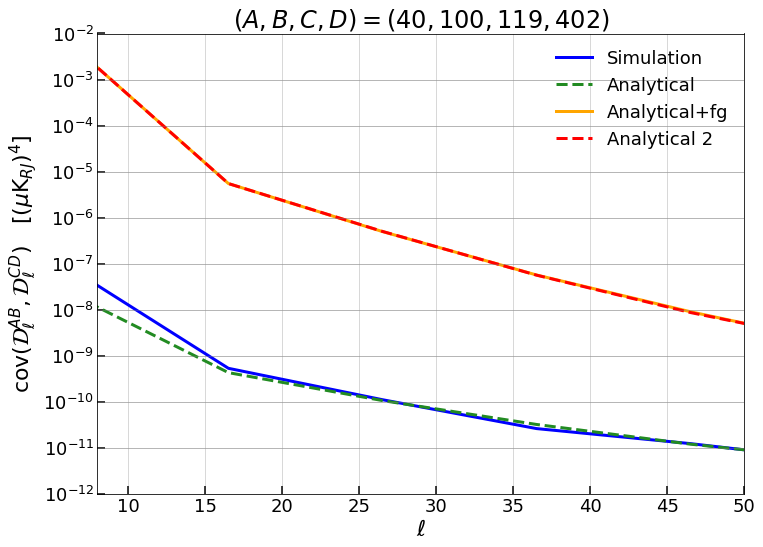

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator

freq1, freq2, freq3, freq4 = 40, 100, 119, 402

plt.rcParams.update({
    'font.size': 20,  
    'axes.labelsize': 22,
    'axes.titlesize': 24,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18
})

plt.figure(figsize=(11, 8)) 

poscrossAB = np.argwhere(nucross == np.sqrt(freq1 * freq2))[0, 0]
poscrossCD = np.argwhere(nucross == np.sqrt(freq3 * freq4))[0, 0]

plt.plot(leff, cov_add[:, poscrossAB, poscrossCD], label='Simulation', color='blue', linewidth=3)
plt.plot(leff, cov_analytic(freq1, freq2, freq3, freq4), label='Analytical', color='forestgreen', linestyle='--', linewidth=3)
plt.plot(leff, cov_analytic(freq1, freq2, freq3, freq4,corrfog=False), label='Analytical+fg', color='orange', linestyle='-', linewidth=3)
plt.plot(leff, cov_analytic_signal(freq1, freq2, freq3, freq4), label='Analytical 2', color='red', linestyle='--', linewidth=3)

plt.title(r'$(A,B,C,D)=(%d, %d, %d, %d)$' % (freq1, freq2, freq3, freq4))
plt.xlabel(r'$\ell$')
plt.ylabel(r'${\rm cov}(\mathcal{D}_\ell^{AB},\mathcal{D}_\ell^{CD}) \quad[(\mu {\rm K}_{RJ})^4]$')

ax = plt.gca()
ax.set_yscale('log')

yticks = 10.0 ** np.arange(-12, 1, 1)
ax.set_yticks(yticks)
for y in yticks:
    ax.axhline(y=y, color='gray', linestyle='-', linewidth=0.75, alpha=0.5)  
ax.grid(True, which='major', linestyle='-', linewidth=0.7, alpha=0.7)
ax.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.4)
ax.tick_params(axis='both', which='major', direction='in', length=8, width=1.5)
ax.tick_params(axis='both', which='minor', direction='in', length=4, width=1)
plt.xlim([8, 50])
plt.ylim([1e-12, 1e-2])
plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
plt.savefig('./%sx%s_%sx%s_leo.pdf' % (freq1, freq2, freq3, freq4), dpi=300)
plt.show()